In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

from baselines import load_comments_and_labels, assemble_data, one_hot
from ngram import test_cross,calibration_curve_plotter,two_class_roc_plotter, two_class_precision_recall_plotter
import matplotlib.pyplot as plt
import joblib
import os
from serialization import save_pipeline, load_pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 98 ms


In [7]:
def eval_n_save_model(task, model_name, debug=False):
    cv_path = '../../models/cv'
    results_path = '../../models/%s/%s' % (task, model_name)
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    
    #load data
    data = load_comments_and_labels(task)
    
    
    if 'edp' in model_name:
        X_train, y_train = assemble_data(data, 'comments', 'empirical_dist', splits = ['train', 'dev'])
        X_test, y_test = assemble_data(data,  'comments', 'empirical_dist', splits = ['test'])
    else:
        X_train, y_train = assemble_data(data, 'comments', 'plurality', splits = ['train', 'dev'])
        X_test, y_test = assemble_data(data,  'comments', 'plurality', splits = ['test'])
        
    if debug:
        X_train = X_train[:1000]
        y_train = y_train[:1000]
        X_test = X_test[:1000]
        y_test = y_test[:1000]
        
    
    #load architecture
    
    model = load_pipeline(cv_path, model_name)
    
    
    #fit model on train and dev eval on test
    model.fit(X_train, y_train)
    
    # metrics
    roc_df, spearman_df = test_cross(model, data, 'comments')
    roc_df.to_csv(os.path.join(results_path, 'roc.csv'))
    spearman_df.to_csv(os.path.join(results_path, 'spearman.csv'))
    
    y_test_oh = one_hot(y_test)
    y_pred_ed = model.predict_proba(X_test)
    
    calibration_curve_plotter(y_test_oh[:, 1], y_pred_ed[:, 1])
    plt.savefig(os.path.join(results_path, 'calibration.png'))
    
    two_class_roc_plotter(y_test, y_pred_ed)
    plt.savefig(os.path.join(results_path, 'roc_curve.png'))
    
    two_class_precision_recall_plotter(y_test, y_pred_ed)
    plt.savefig(os.path.join(results_path, 'precision_recall_curve.png'))
    
    
    if 'edp' in model_name:
        X, y = assemble_data(data, 'comments', 'empirical_dist')
    else:
        X, y = assemble_data(data, 'comments', 'plurality')
        
        
    if debug:
        X=X[:1000]
        y=y[:1000]
        
        
    save_pipeline(model.fit(X, y), results_path, model_name )

time: 1.31 s


In [8]:
tasks = ['recipient', 'attack', 'aggression']
models = ['linear_tfidf', 'edp_tfidf']

time: 1.37 ms


Epoch 1/4
92660/92660 [==============================] - 19s - loss: 0.1259 - acc: 0.9457    
Epoch 2/4
92660/92660 [==============================] - 14s - loss: 0.0663 - acc: 0.9630    
Epoch 3/4
92660/92660 [==============================] - 14s - loss: 0.0608 - acc: 0.9671    
Epoch 4/4
23168/23168 [==============================] - 1s     
Epoch 1/4
115828/115828 [==============================] - 26s - loss: 0.1133 - acc: 0.9495    
Epoch 2/4
115828/115828 [==============================] - 21s - loss: 0.0645 - acc: 0.9638    
Epoch 3/4
115828/115828 [==============================] - 18s - loss: 0.0590 - acc: 0.9667    
Epoch 4/4
115828/115828 [==============================] - 18s - loss: 0.0550 - acc: 0.9698    
Epoch 1/4
92660/92660 [==============================] - 20s - loss: 0.1434 - acc: 0.9218    
Epoch 2/4
92660/92660 [==============================] - 12s - loss: 0.0800 - acc: 0.9511    
Epoch 3/4
92660/92660 [==============================] - 14s - loss: 0.0730 - acc

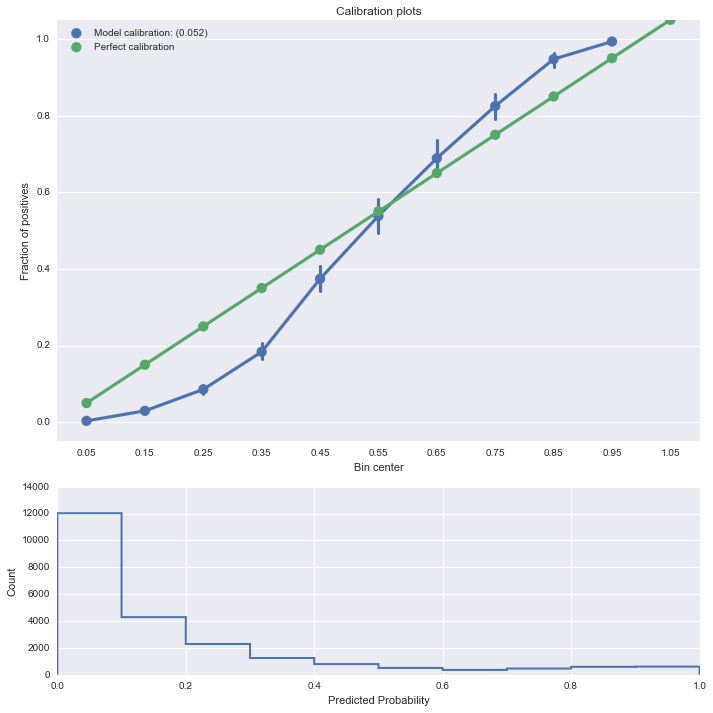

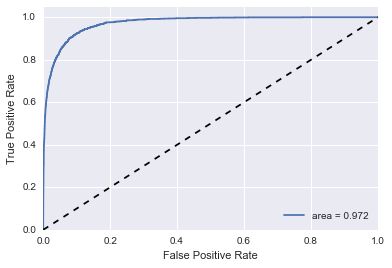

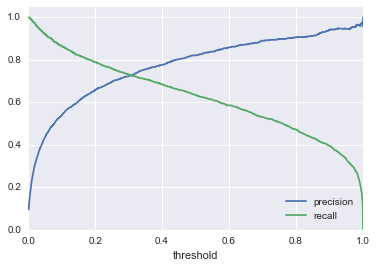

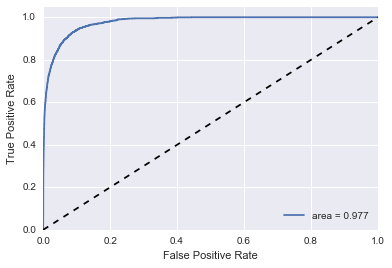

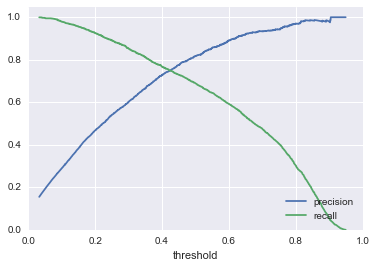

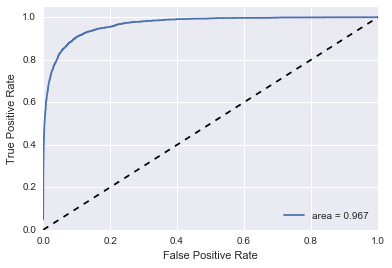

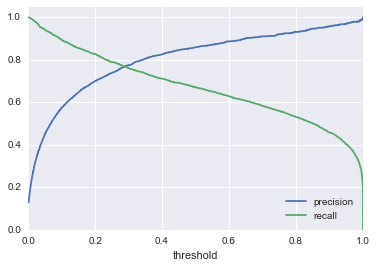

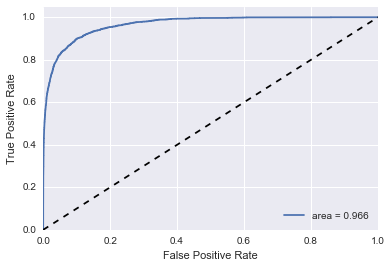

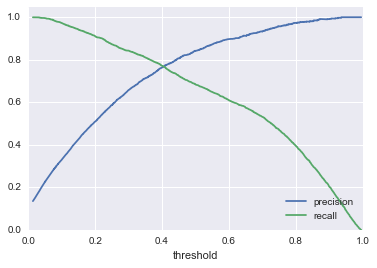

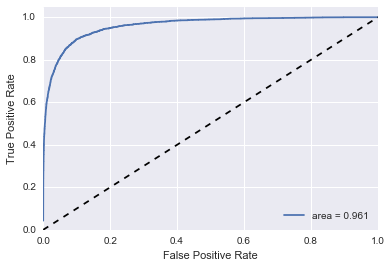

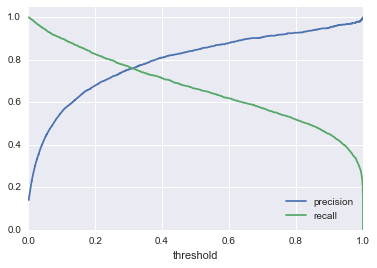

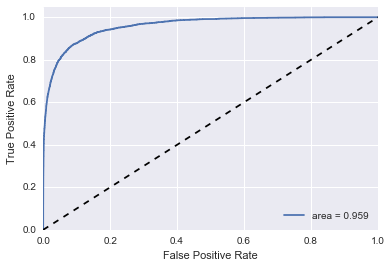

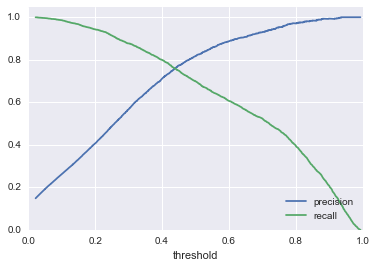

time: 1h 16min 41s


In [9]:
for task in tasks:
    for model in models:
        eval_n_save_model(task, model, debug = False)